# CSV to DXF converter

This script gets a file produced by the ski scanner, which is a CSV type containing information on displacement and width, and transforms it into a dxf file which is the input for the laser cutting machine used at Pomoca.

## CSV file read


[note] For now the file is meant for raw noisy data

Import libraries

In [1120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ezdxf as dxf
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
from itertools import groupby
import math 
import scipy.signal
import warnings
import plotly
import cufflinks
pd.options.plotting.backend = "plotly"
warnings.simplefilter('ignore')
%matplotlib notebook

Import inputs: insettino geometric data, ski nominal length and csv file from sensors

In [1121]:
# Insettino geometric data
r = 8.097 #cm Arms
dx = 3.15 #cm
dy = 1.505 #cm
pins_offset = 2.78 # cm (distance between 2 pins)/2
d = 8 #cm distance between two rotary encoders
offsetW1 = r-dx #cm
offsetW2 = r-dx #cm

ski_nominal_length = 176 #cm
ski_nominal_minwidth = 7.7 #cm
ski_nominal_maxwidth_tip = 11.4 #cm

# Reading raw data (directory\filename.txt)
df = pd.read_csv(r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Test insettino v2\Speed carbon 76 176\prova59.txt', sep = ",")
# Output:
dxf_filename = r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Test insettino v2\Speed carbon 76 176\Speed_carbon_76_176-test1_scaled.dxf'
# drop NaN column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop rows with all NaN values
df = df.dropna(axis=0, how='all')

df

,ID,timestamp,L1,W1,L2,W2
0,1,451319,0.00,5.56,0.00,5.56
1,2,453101,0.00,5.56,0.00,5.57
2,3,453155,0.00,5.56,0.00,5.58
3,4,453209,0.00,5.56,0.00,5.60
4,5,453263,0.00,5.56,0.00,5.65
...,...,...,...,...,...,...
907,908,537704,175.94,5.35,176.38,5.48
908,909,537760,175.94,5.35,176.37,5.48
909,910,537872,175.94,5.35,176.38,5.48
910,911,537984,175.94,5.35,176.40,5.48


r,dx,dy
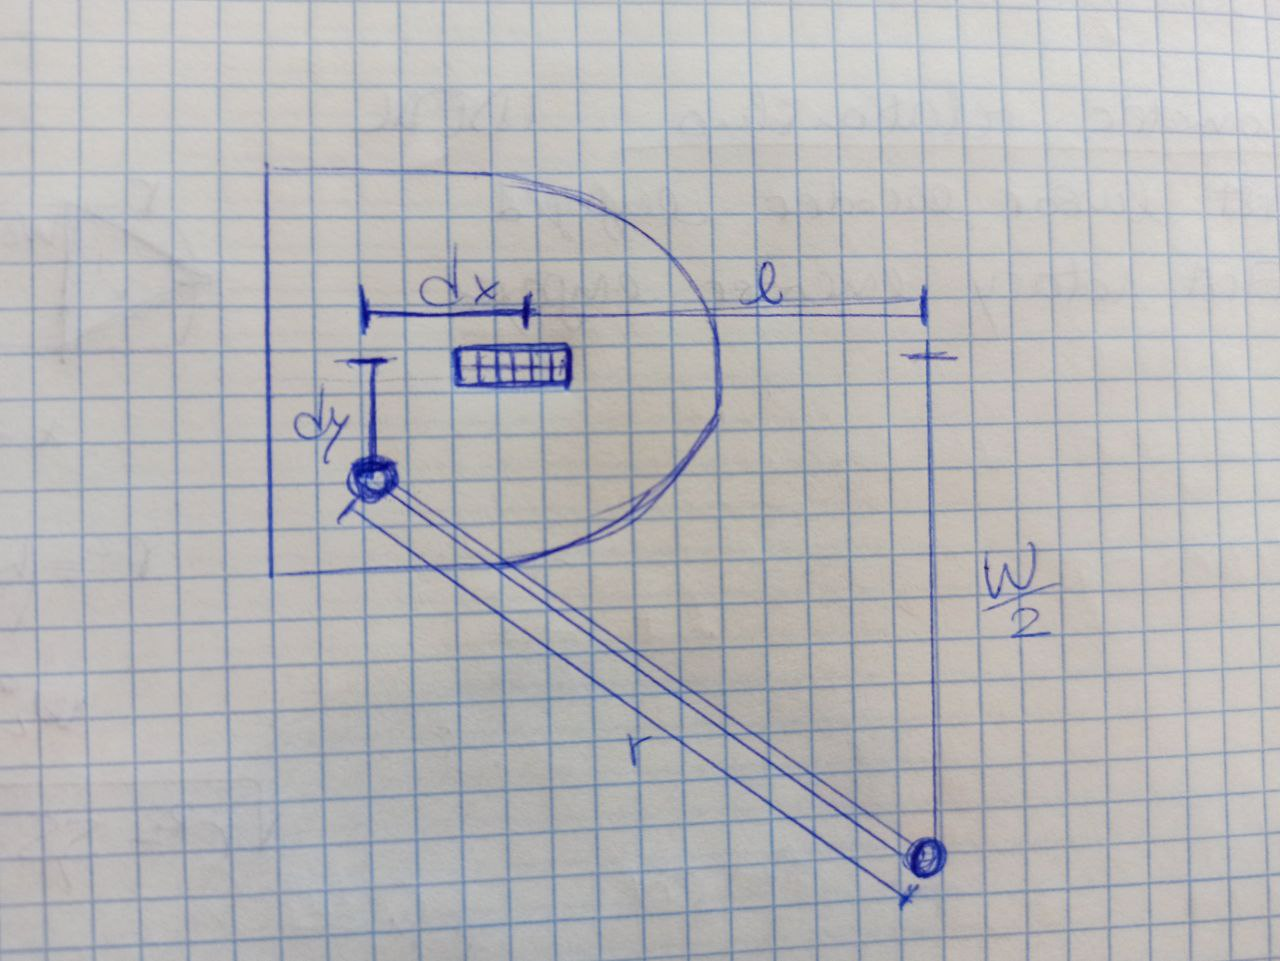

Adjust data from sensors: half width

In [1122]:
df['W1'] = df['W1']/2  # df['W1']/2 # for inverted data: -(df['W1']/2 - (pins_offset*2)) #  Half width to plot profile
df['W2'] = df['W2']/2 # Half width to plot profile

#df['L2'] = -df['L2'] # One encoder rotates in the opposite way so it detects negative length
#df['L1'] = -df['L1'] # One encoder rotates in the opposite way so it detects negative length

<IPython.core.display.Javascript object>


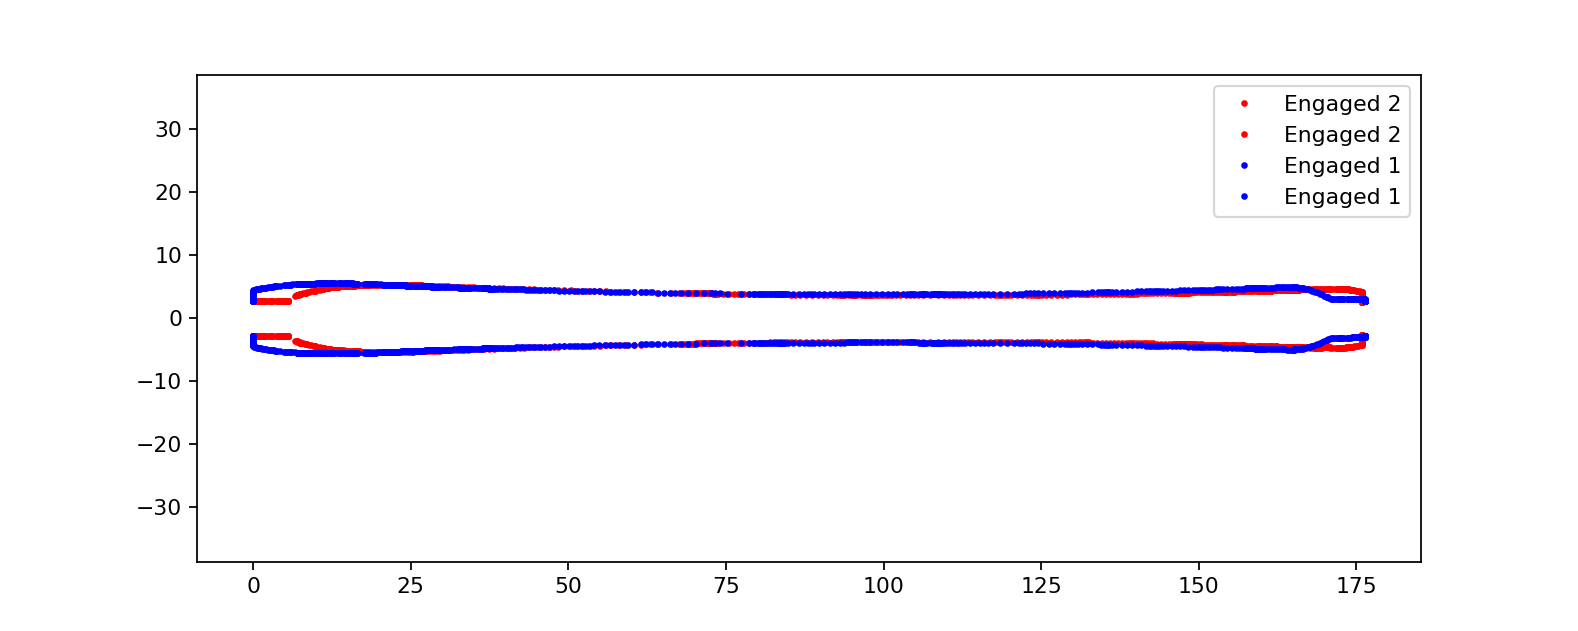

In [1123]:
# Plot two sides of the ski

plt.figure(figsize=(10, 4))

plt.plot(df['L1'], df['W1'], 'ro', markersize=2)
plt.plot(df['L1'], -df['W1'], 'ro', markersize=2)

plt.plot(df['L2'], df['W2'], 'bo', markersize=2)
plt.plot(df['L2'], -df['W2'], 'bo', markersize=2)

plt.legend(['Engaged 2', 'Engaged 2', 'Engaged 1', 'Engaged 1'])
plt.axis('equal')
plt.show()

Compute and plot gradient W with spacing L

In [1124]:
#df[['L1','W1']] = df[['L1','W1']].sort_values('L1',ascending=True)
gradient1 = np.gradient(df['W1'],df['L1'])
#plt.figure()
#plt.plot(df['L1'],gradient1,'r')
#plt.show()

In [1125]:
#df[['L2','W2']] = df[['L2','W2']].sort_values('L2',ascending=True)
gradient2 = np.gradient(df['W2'],df['L2'])
#plt.figure()
#plt.plot(df['L2'],gradient2,'b')
#plt.show()

Definition of functions needed to align the measures of lengths and widths

In [1126]:
def offset_forward(frame_l,frame_w):
    offset = (np.sqrt(r**2 - (frame_w-dy)**2))-dx
    l_transformed = frame_l + offset
    return l_transformed
def offset_backward(frame_l,frame_w):
    offset = (np.sqrt(r**2 - (frame_w-dy)**2))-dx
    l_transformed = frame_l - offset
    return l_transformed

Definition of function to compute difference of variances of consecutive windows 

In [1127]:
def var_differences(df,window_length):
    previous_window_var = pd.DataFrame()
    differences = pd.DataFrame()
    for window in df.rolling(window=window_length):
        #if window.size<window_length:
            #print(window.size)
            #continue
        curr_window_var = window.var()
        diff = previous_window_var - curr_window_var
        differences = differences.append(diff, ignore_index=True)
        previous_window_var = curr_window_var
        #print(window)
        #print(variance)
    differences = differences.dropna(axis=0, how='all')
    return differences

Identification of engagement of the first couple of sensors (rotary encoder + linear encoder = L + W) !to be fixed 

<IPython.core.display.Javascript object>


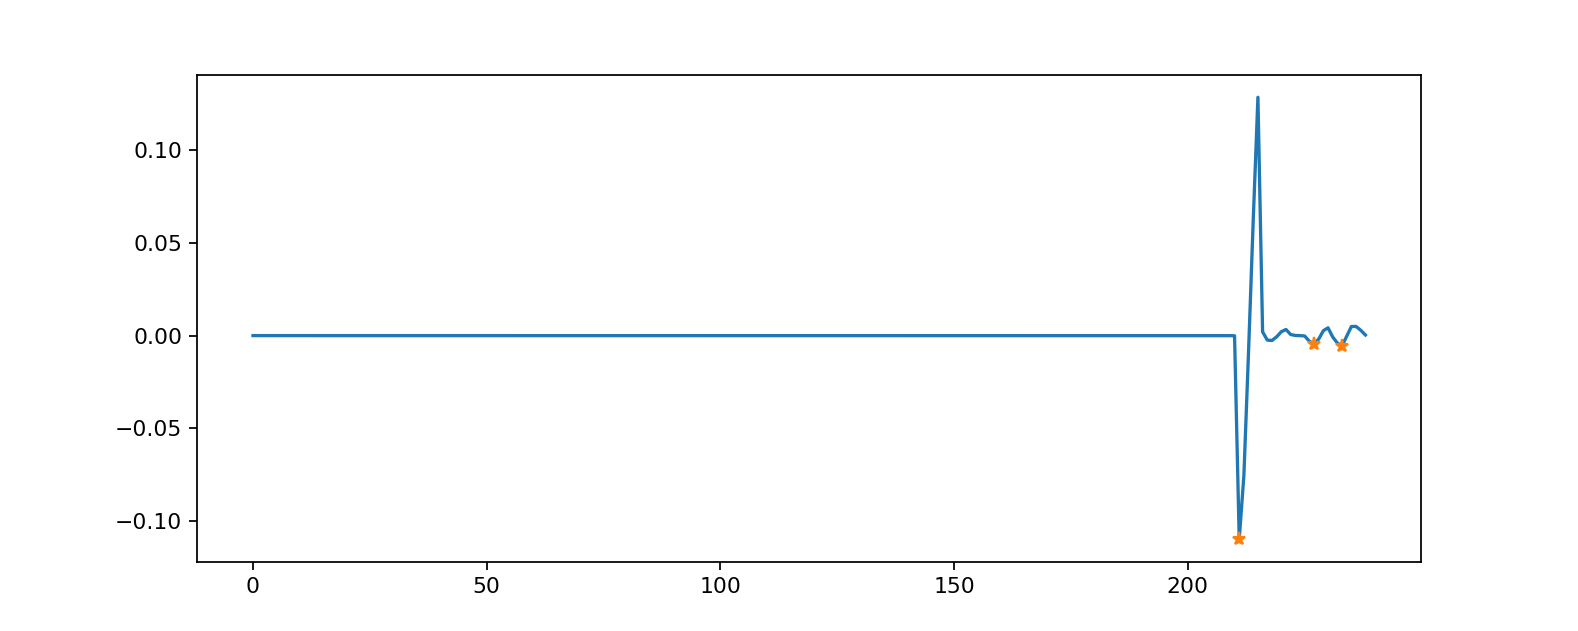

211
2.8


In [1128]:
#Selection of interval for start_L1 detection: when W1 starts changing
epsilon = 5 #cm #acceptable error
starting_interval = df[['L1','W1']][df['L1']<offsetW1+epsilon]
df1 = pd.DataFrame({'W1':starting_interval['W1']})
window_length = 5
differences = var_differences(df1, window_length)
array_differences = differences.to_numpy()[:,0]

peaks, _ = scipy.signal.find_peaks(-array_differences,prominence=0.008)

plt.figure(figsize=(10, 4))
plt.plot(array_differences)#df['L1'][1:],
plt.plot(peaks,array_differences[peaks],'*')
#plt.axis('equal')
plt.show()
start_L1 = peaks[0]
start_L1_value = df1.iloc[peaks[0]].to_numpy()[0]
print(start_L1)
print(start_L1_value)
df[['L1','W1']] = df[['L1','W1']][start_L1:]
    

<IPython.core.display.Javascript object>


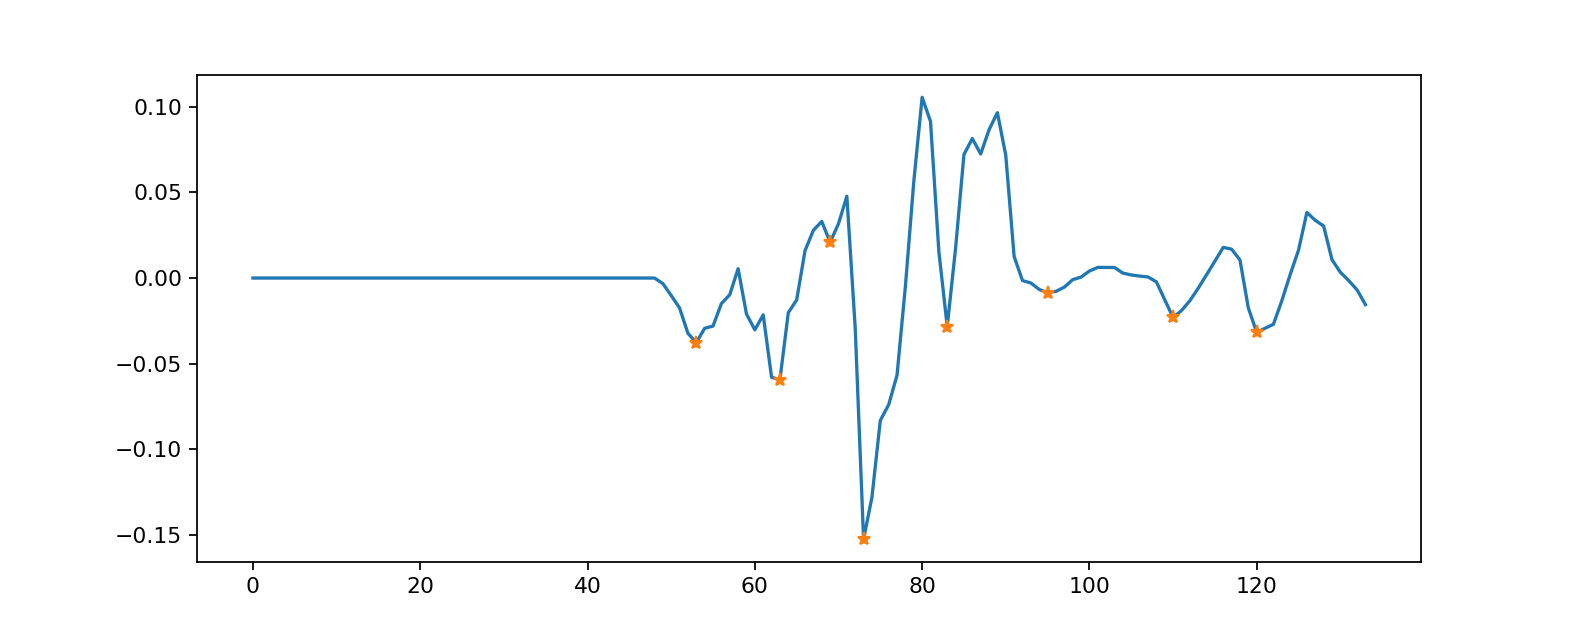

53
0.45


In [1129]:
#Selection of interval for start_L2 detection: when L2 starts changing
epsilon = 10 #cm #acceptable error
starting_interval = df[['L2','W2']][df['L2']<epsilon]
df2 = pd.DataFrame({'L2':starting_interval['L2']})
window_length = 10
differences = var_differences(df2,window_length)
array_differences = differences.to_numpy()[:,0]

peaks, _ = scipy.signal.find_peaks(-array_differences,prominence=0.01)

plt.figure(figsize=(10, 4))
plt.plot(array_differences)#df['L1'][1:],
plt.plot(peaks,array_differences[peaks],'*')
#plt.axis('equal')
plt.show()
start_L2 = peaks[0]
start_L2_value = df2.iloc[peaks[0]].to_numpy()[0]
print(start_L2)
print(start_L2_value)
df[['L2','W2']] = df[['L2','W2']][start_L2:]

# Detect when rotary encoder 2 is engaged (L2 start): Detect changes in L2 data 
changes = df['L2'].pct_change(periods=5)

#start_L2 = df['L2'][(changes>0.9)].index.values[0]#& (df['W2'] > df['W2'].max()*0.89)].index.values[0] # to be fixed
start_L2 = df['L2'][(changes>0.9)].index.values[0]
#plt.figure()
#plt.plot(df['L2'],changes)
#plt.show()

# Similarly you can evaluate the gradient you compute
start_L2 = (np.where((gradient2 > 0.3) & (gradient2 != float('Inf'))))[0]
start_L2 = start_L2[0]

Rephasing of W2 and L2 data

In [1130]:
# Keep only W2-L2 data after the engagement
df[['L2','W2']] = df[['L2','W2']].loc[start_L2:]

# Reset offset of Length2 that might have been accidentally accumulated before the engagement 
#df['L2'] = df['L2'] - df['L2'].loc[start_L2]

# Add geometrical offset
df['L2'] = offset_forward(df['L2'],df['W2'])
# Visualise the very first starting data
# df[['L2','W2']].dropna(axis=0, how='all')

Identification of engagement of the second couple of sensors (rotary encoder + linear encoder = L + W) !to be fixed 

# Detect when linear encoder 1 is engaged (W1 starts changing becoming greater than the starting offset)
# In theory when W1 data start changing but geometrically it is engaged when L1 is 9.5 cm far and L2 is 9.5 + 8 cm far
changes = df['W2'].pct_change(periods=10)
#plt.figure()
#plt.plot(df['L2'],changes)
#plt.show()

# changes2 = df['W1'].pct_change(periods=10)
start_L1 = df['L1'][(df['W1']>= pins_offset+0.01)].index.values[0]

Rephasing of W1 and L1 data

In [1131]:
# Keep only W1-L1 data after the engagement
df[['L1','W1']] = df[['L1','W1']].loc[start_L1:] 

# Subtract geometrical offset
df['L1'] = offset_backward(df['L1'],df['W1'])

# Reset offset of Length1 that might have been accidentally accumulated before the engagement
df['L1'] = df['L1'] - df['L1'].loc[start_L1]

# Visualise the very first starting data
#df[['L1','W1']].dropna(axis=0, how='all')

Plot two sides of the ski with tip data fixed

<IPython.core.display.Javascript object>


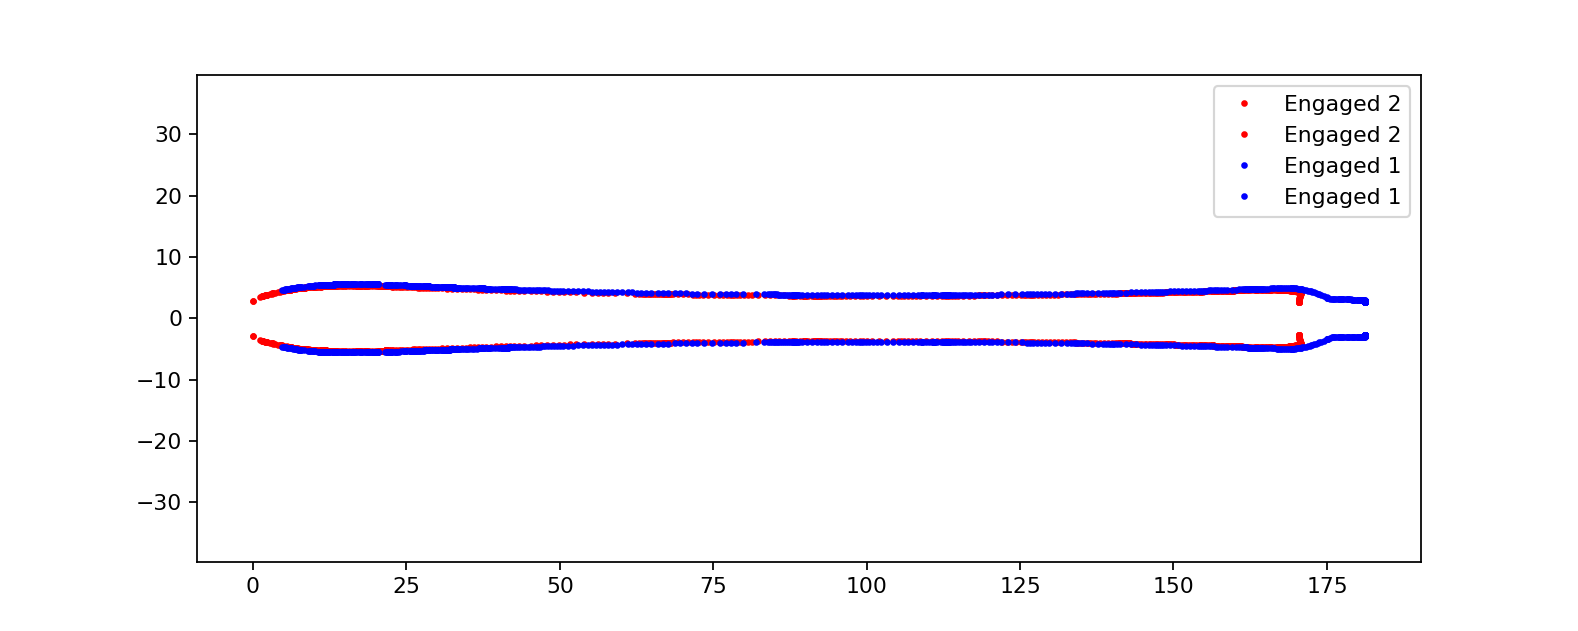

In [1132]:
# Plot two sides of the ski

plt.figure(figsize=(10, 4))

plt.plot(df['L1'], df['W1'], 'ro', markersize=2)
plt.plot(df['L1'], -df['W1'], 'ro', markersize=2)

plt.plot(df['L2'], df['W2'], 'bo', markersize=2)
plt.plot(df['L2'], -df['W2'], 'bo', markersize=2)

plt.legend(['Engaged 2', 'Engaged 2', 'Engaged 1', 'Engaged 1'])
plt.axis('equal')
plt.show()

Identification of disengagement of the first couple of sensors (rotary encoder + linear encoder = L + W) !to be fixed 

<IPython.core.display.Javascript object>


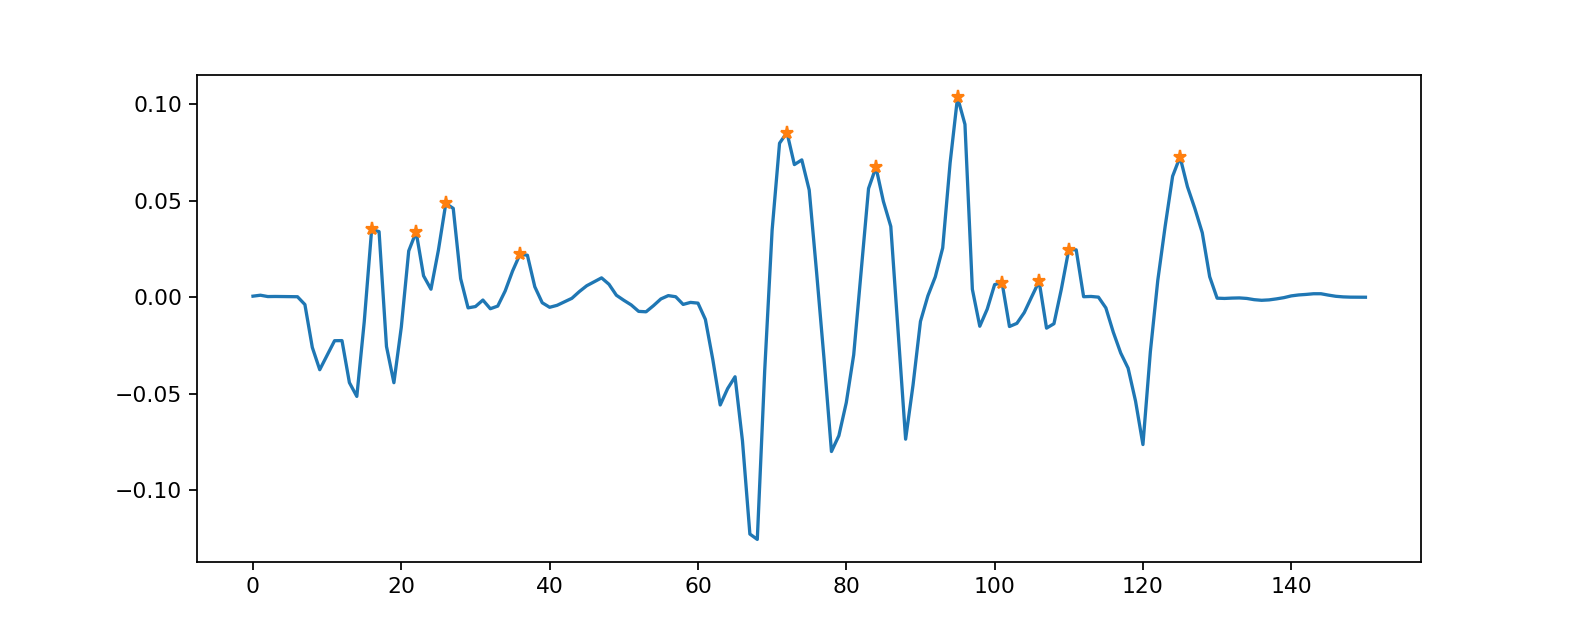

125
170.75040303766326


In [1133]:
#Selection of interval for end_L1 detection: when L1 stops
epsilon = 20 #cm #acceptable error
starting_interval = df[['L1','W1']][df['L1']>(ski_nominal_length-epsilon)]
df3 = pd.DataFrame({'L1':starting_interval['L1']})
window_length = 10
differences = var_differences(df3,window_length)
array_differences = differences.to_numpy()[:,0]

peaks, _ = scipy.signal.find_peaks(array_differences,prominence=0.02)

plt.figure(figsize=(10, 4))
plt.plot(array_differences)#df['L1'][1:],
plt.plot(peaks,array_differences[peaks],'*')
#plt.axis('equal')
plt.show()
end_L1 = peaks[-1]
end_L1_value = df3.iloc[end_L1].to_numpy()[0]
print(end_L1)
print(end_L1_value)

#df[['L1','W1']] = df[['L1','W1']][df['L1']<=end_L1_value]
df[['L1','W1']] = df[['L1','W1']].drop(df[['L1','W1']][((df['W1'] < starting_interval['W1'][end_L1:].iloc[0]) & (df['L1'] > ski_nominal_length-epsilon))].index)

<IPython.core.display.Javascript object>


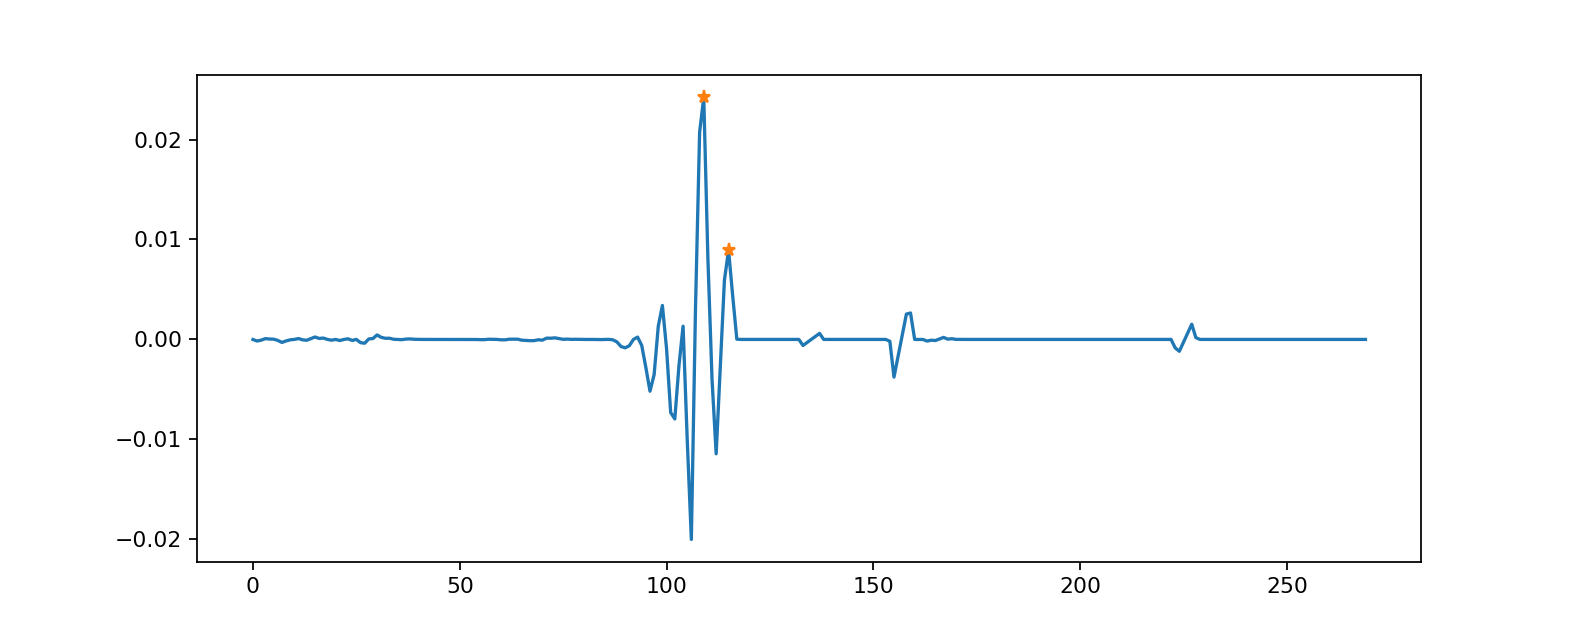

115
3.085


In [1134]:
#Selection of interval for end_L2 detection: when W2 stops
epsilon = 30 #cm #acceptable error
starting_interval = df[['L2','W2']][df['L2']>(ski_nominal_length-epsilon)]
df4 = pd.DataFrame({'W2':starting_interval['W2']})
window_length = 5
differences = var_differences(df4,window_length)
array_differences = differences.to_numpy()[:,0]

peaks, _ = scipy.signal.find_peaks(array_differences,prominence=0.01)

plt.figure(figsize=(10, 4))
plt.plot(array_differences)#df['L1'][1:],
plt.plot(peaks,array_differences[peaks],'*')
#plt.axis('equal')
plt.show()
end_L2 = peaks[-1]
end_L2_value = df4.iloc[end_L2].to_numpy()[0]
print(end_L2)
print(end_L2_value)
#df[['L1','W1']] = df[['L1','W1']][df['L1']<=end_L1_value]
df[['L2','W2']] = df[['L2','W2']].drop(df[['L2','W2']][(df['L2'] > starting_interval['L2'][end_L2:].iloc[0])].index)

# Detect when linear encoder 2 is disengaged (W2 ends)
# Conditions: around the nominal length of the ski, W2 stops changing 
end_L2 = df['L2'][(df['L2']<ski_nominal_length) & (df['L2']>ski_nominal_length-40) & (abs(df['W2'].shift(1)-df['W2'])>0.05) & (abs(df['W2'].shift(3)-df['W2'])>0.05) & (abs(df['W2'].shift(5)-df['W2'])>0.05)].index.values[-1]

# Keep only W2-L2 data before the disengagement
df['L2'] = df['L2'].loc[:end_L2]

# Detect when rotary encoder 1 is disengaged (L1 ends)
# Conditions: around the nominal length of the ski, L1 not changing anymore
end_L1 = df['L1'][(df['L1']>ski_nominal_length-40) & (df['L1'].shift(-1)-df['L1']<0.1)].index.values[0]

# Keep only W1-L1 data before the disengagement
df['L1'] = df['L1'].loc[:end_L1]

<IPython.core.display.Javascript object>


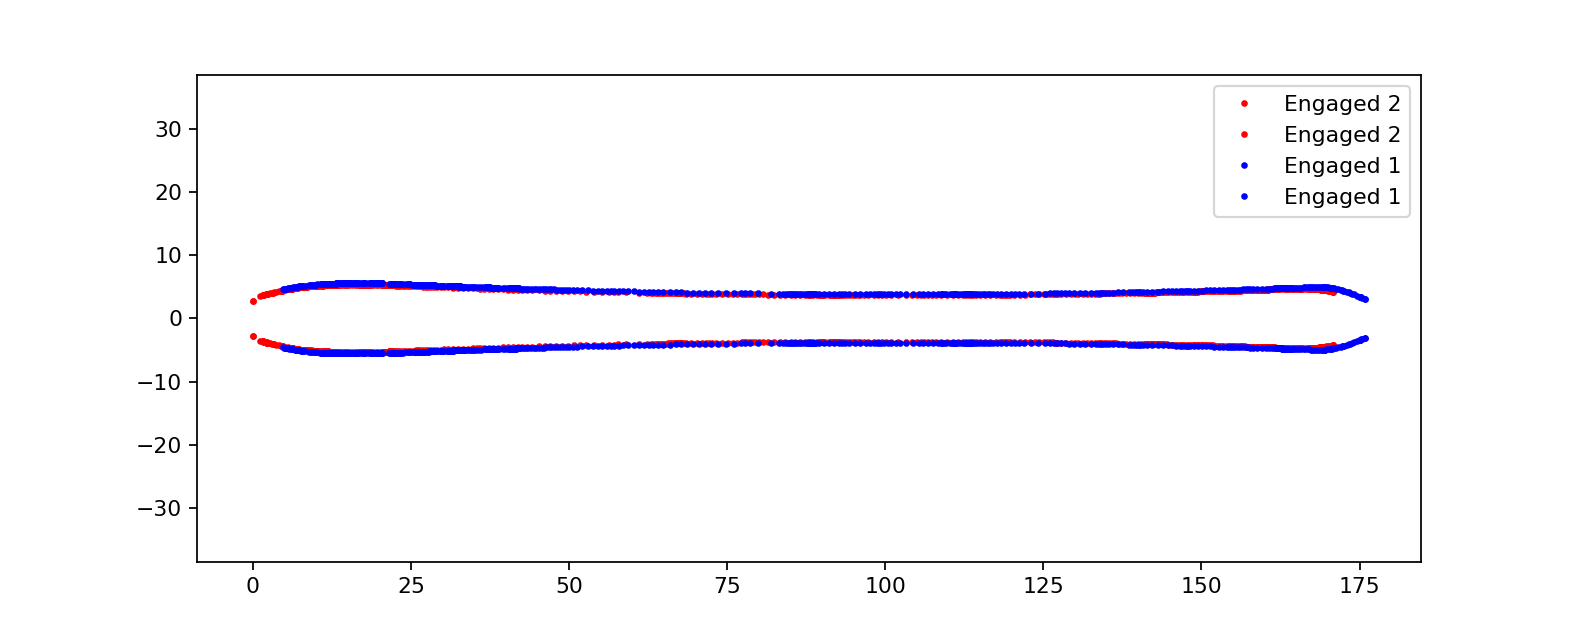

In [1135]:
# Plot two sides of the ski

plt.figure(figsize=(10, 4))

plt.plot(df['L1'], df['W1'], 'ro', markersize=2)
plt.plot(df['L1'], -df['W1'], 'ro', markersize=2)

plt.plot(df['L2'], df['W2'], 'bo', markersize=2)
plt.plot(df['L2'], -df['W2'], 'bo', markersize=2)

plt.legend(['Engaged 2', 'Engaged 2', 'Engaged 1', 'Engaged 1'])
plt.axis('equal')
plt.show()

In [1136]:
# Drop rows with all NaN values
df = df.dropna(axis=0, how='all')

# Merging data from 2 couples of sensors data in one single ski profile

In this section an approach of mean computation of the nearest points is implemented:
For each point coming from one couple of sensors an interval of the closest points from the other couple of sensors is selected, the euclidean distance from each point of the interval is computed and the nearest is select for the mean computation. 

In [1137]:
# Start iterating the secondly engaged sensors: when I get closed to firstly engaged sensor I start mediating
start_L2 = df['L2'].min() #After all sensors are engaged the merging should begin (Start_L2 represents the starting moment)
delta = 5 #Maximum distance from the current point included in the interval of the closest points

ski_profile = pd.DataFrame(columns=['W','L'])

for i in range(1,len(df['L1'])): #iterate the secondly-engaged sensors data
    
    if (df['L1'].iloc[i] < start_L2): #at the beginning no merging is needed: save all data points in ski profile
        df_temp = pd.DataFrame(df[['W1','L1']].iloc[i]).transpose()
        df_temp = df_temp.rename(columns={"W1": "W", "L1": "L"})
        ski_profile = ski_profile.append(df_temp)
        
    elif (df['L1'].iloc[i] >= start_L2): # When both sets of data are available save their mean in ski profile
        
        #find closest value of firstly engaged sensors
        close_interval = df[['W2','L2']][abs(df['L1'].iloc[i]-df['L2']) < delta] 
        min_dist = 1000 #initialise the minimum distance to a very high value
        closest_value = [] #initialise a variable to save the closest point among the points in the interval
        for j in range(1,len(close_interval)): #iterate over the selected interval
            a = df[['W1','L1']].iloc[i].to_numpy()
            b = close_interval.iloc[j].to_numpy()
            dist = np.linalg.norm(a-b)
            if (dist < min_dist):
                min_dist = dist
                closest_value = pd.DataFrame(close_interval.iloc[j]).transpose()
                closest_value = closest_value.rename(columns={"W2": "W", "L2": "L"})
                curr_point = pd.DataFrame(df[['W1','L1']].iloc[i]).transpose()
        curr_point = curr_point.rename(columns={"W1": "W", "L1": "L"})
        mean_point = pd.DataFrame(curr_point.append(closest_value).mean()).transpose() #compute the mean between two the closest value and the current value
        ski_profile = ski_profile.append(mean_point) #save mean in ski profile


In [1138]:
# At the end no merging is needed: save all data points in ski profile
# Add tail to ski profile
tail = df[['W2','L2']][df['L2']> df['L1'].dropna(axis=0, how='all').iloc[-1]]
tail = tail.rename(columns={"W2": "W", "L2": "L"})
ski_profile = ski_profile.append(tail)

<IPython.core.display.Javascript object>


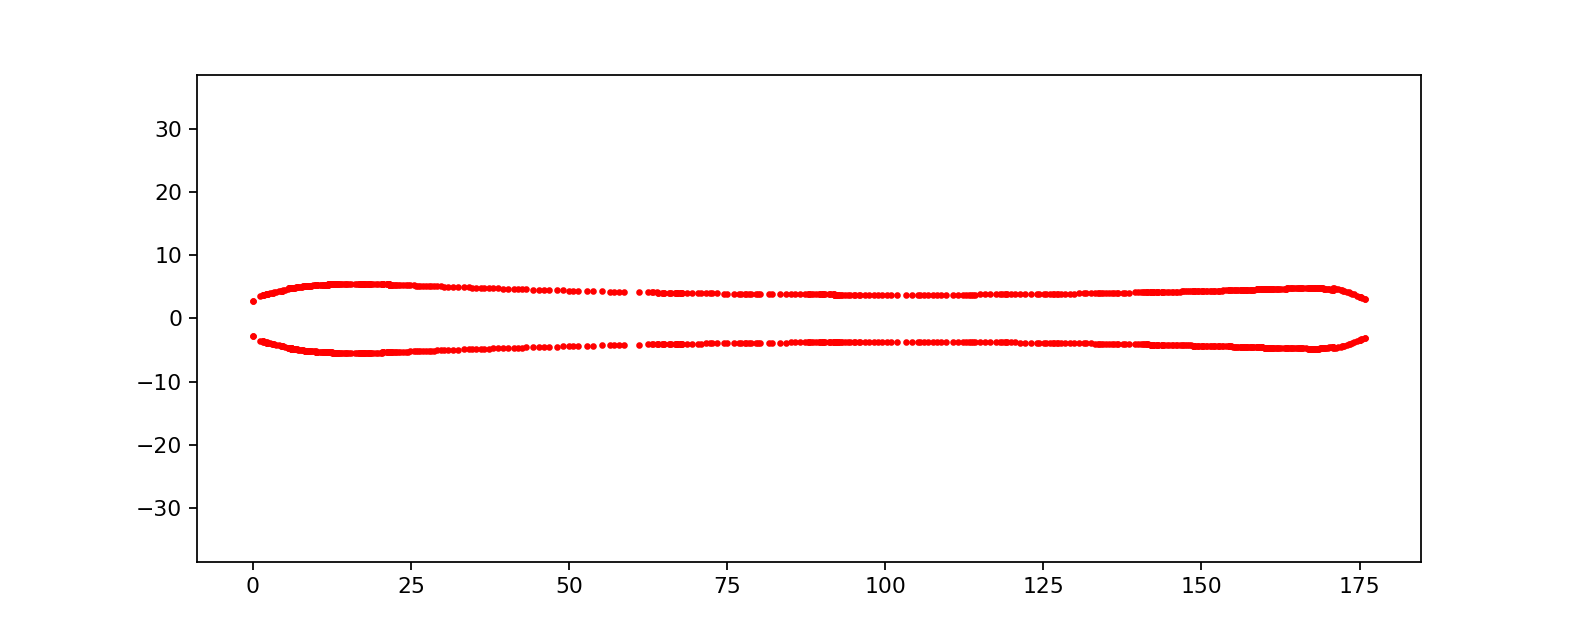

In [1139]:
# Plot two sides of the ski

plt.figure(figsize=(10, 4))

plt.plot(ski_profile['L'], ski_profile['W'], 'ro', markersize = 2)
plt.plot(ski_profile['L'], -ski_profile['W'], 'ro', markersize = 2)

plt.axis('equal')
plt.show()

In [1140]:
# For Isabella
# ski_profile.to_csv(r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\sensorsdata.csv', index = False)

# For Raph (Mac)
ski_profile.to_csv(r'sensorsdata.csv', index = False)

# Spline generation and saving in dxf file

Division of data in sections (from 0 to 14% of length for tip section, from 94% of length to end for tail section) and spline generation

Define function to find the closest point of a dataframe array to a point

In [1141]:
def closest_point(point, df):
    delta = 10
    close_interval = df[abs(df-point) < delta] 
    min_dist = 1000 #initialise the minimum distance to a very high value
    closest_value = [] #initialise a variable to save the closest point among the points in the interval
    for j in range(1,len(close_interval)): #iterate over the selected interval
        
        a = point
        b = close_interval.iloc[j]
        
        dist = np.linalg.norm(a-b)
        if (dist < min_dist):
            min_dist = dist
            closest_value = b
    
    return closest_value

Selection of section extremes and extreme tangent computation

In [1142]:
def local_slope(point,df):
    delta = 20
    df_array_l = df['L'].to_numpy()
    df_array_w = df['W'].to_numpy()
    center, = np.where(np.isclose(df_array_l, point))
    
    #center = df[df['L'] == point].index[0]
    x = df_array_l[int(center-delta):int(center+delta)]
    y = df_array_w[int(center-delta):int(center+delta)]
    model = np.polyfit(x, y, 1)
    f = np.poly1d(model)
    out = (1,f(1)-model[1],0)  
    #plt.plot(x,y,'*')
    #plt.plot(x,f(x),'-')
    #print(out)
    return out


In [1143]:
ski_profile = ski_profile.sort_values('L',ascending=True)
max_length = ski_profile['L'].max()

start_section1 = closest_point(0*max_length,ski_profile['L'])
start_section1_4tangent = closest_point(0.01*max_length,ski_profile['L'])
#tangent_start_section1 = local_slope(start_section1_4tangent, ski_profile)

In [1144]:
end_section1 = closest_point(0.14*max_length,ski_profile['L']) 
tangent_end_section1 = local_slope(end_section1, ski_profile)

In [1145]:
start_section2 = end_section1
#tangent_start_section2 = local_slope(start_section2, ski_profile)

end_section2 = closest_point(0.94*max_length,ski_profile['L'])
tangent_end_section2 = local_slope(end_section2, ski_profile)

In [1146]:
start_section3 = end_section2
end_section3 = max_length
end_section3_4tangent = closest_point(0.999*max_length,ski_profile['L'])
#tangent_end_section3 = local_slope(end_section3_4tangent, ski_profile)

Generation of splines for control points smoothing and plot

<IPython.core.display.Javascript object>


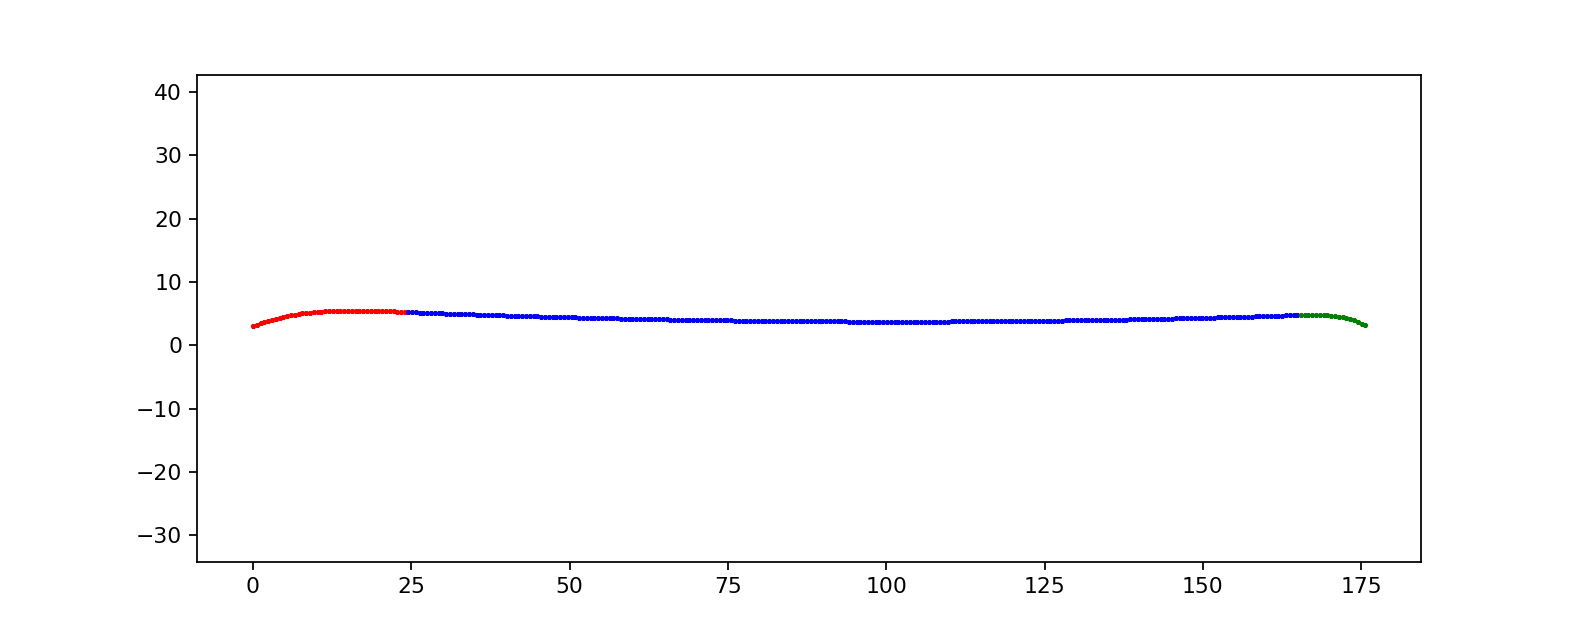

In [1147]:
plt.figure(figsize=(10, 4))
dx = 0.6

section1 = ski_profile[['L','W']][ (ski_profile['L']>=start_section1) & (ski_profile['L']<=end_section1)]
myspline1 = scipy.interpolate.UnivariateSpline(section1['L'].to_numpy(), section1['W'].to_numpy())
x1 = np.arange(start_section1, end_section1, dx)
y_myspline1 = myspline1(x1)
plt.plot(x1, y_myspline1, 'r*', markersize = 2)
#plt.plot(section1['L'], section1['W'], 'r*', markersize=2)
#plt.plot(section1['L'], section1['W'], 'r*', markersize=2)

section2 = ski_profile[['L','W']][ (ski_profile['L']>=start_section2) & (ski_profile['L']<=end_section2)]
myspline2 = scipy.interpolate.UnivariateSpline(section2['L'].to_numpy(), section2['W'].to_numpy())
x2 = np.arange(start_section2, end_section2, dx)
y_myspline2 = myspline2(x2)
plt.plot(x2, y_myspline2, 'b*', markersize = 2)
#plt.plot(section2['L'], section2['W'], 'b*', markersize=2)

section3 = ski_profile[['L','W']][ (ski_profile['L']>=start_section3) & (ski_profile['L']<=end_section3)]
myspline3 = scipy.interpolate.UnivariateSpline(section3['L'].to_numpy(), section3['W'].to_numpy())
x3 = np.arange(start_section3, end_section3, dx)
y_myspline3 = myspline3(x3)
plt.plot(x3, y_myspline3, 'g*', markersize = 2)
#plt.plot(section3['L'], section3['W'], 'g*', markersize=2)

plt.axis('equal')
plt.show()

Add splines to dxf modelspace

In [1148]:
# Create a new DXF document.
doc = dxf.new(dxfversion='R2018')
sectionA = []
sectionB = []
# DXF entities (LINE, TEXT, ...) reside in a layout (like modelspace).  
msp = doc.modelspace()

section1 = np.concatenate([x1[:-5,np.newaxis],y_myspline1[:-5,np.newaxis]],axis = 1)
sectionA = np.vstack([section1])
section1 = np.vstack([section1, [start_section2, myspline2(start_section2)]])

section2 = np.concatenate([x2[4:,np.newaxis],y_myspline2[4:,np.newaxis]],axis = 1)
sectionA = np.vstack([sectionA,section2])
section2 = np.vstack([section2, [start_section3, myspline2(start_section3)]])

section3 = np.concatenate([x3[5:,np.newaxis],y_myspline3[5:,np.newaxis]],axis = 1)
sectionA = np.vstack([sectionA,section3])
section3 = np.vstack([[end_section2, myspline2(end_section2)], section3])

section4 = np.concatenate([x1[:-5,np.newaxis],-y_myspline1[:-5,np.newaxis]],axis = 1)
sectionB = np.vstack([section4])
section4 = np.vstack([section4, [start_section2, -myspline2(start_section2)]])

section5 = np.concatenate([x2[4:,np.newaxis],-y_myspline2[4:,np.newaxis]],axis = 1)
sectionB = np.vstack([sectionB,section5])
section5 = np.vstack([section5, [start_section3, -myspline2(start_section3)]])

section6 = np.concatenate([x3[5:,np.newaxis],-y_myspline3[5:,np.newaxis]],axis = 1)
sectionB = np.vstack([sectionB,section6])
section6= np.vstack([[end_section2, -myspline2(end_section2)], section6])

Rescaling data with nominal information

In [1149]:
def length_adj(array,nominal_length):
    maximum = np.amax(array)
    array = (array/maximum)*nominal_length
    return array
def width_adj(array,nominal_minwidth,nominal_maxwidth):
    minimum = np.amin(array[40:-40])
    maximum = np.amax(array[0:(round(len(array)/2))])
    array = (((array-minimum)/(maximum-minimum))*(nominal_maxwidth-nominal_minwidth))+nominal_minwidth 
    return array

#Rescaling with nominal information 
sectionA[:,0] = length_adj(sectionA[:,0],ski_nominal_length)
sectionA[:,1] = width_adj(sectionA[:,1],(ski_nominal_minwidth)/2,(ski_nominal_maxwidth_tip/2))

sectionB[:,0] = length_adj(sectionB[:,0],ski_nominal_length)
sectionB[:,1] = -(width_adj(sectionA[:,1],(ski_nominal_minwidth)/2,(ski_nominal_maxwidth_tip/2)))

max_length = np.amax(sectionA[:,0])
max_width_tip = np.amax(sectionA[0:(round(len(sectionA[:,1])/2)),1])
max_width_tail = np.amax(sectionA[round(len(sectionA[:,1])/2):-1,1])
minimum_width = np.amin(sectionA[40:-40,1])
print(max_length)
print(minimum_width*2)
print(max_width_tip*2)
print(max_width_tail*2)

176.0
7.7
11.4
9.914391643734232


Add splines and lines to DXF file

In [1150]:
# Add entities (spline) to a layout by factory methods: layout.add_...() 
#msp.add_cad_spline_control_frame(fit_points = section1)#, tangents = [tangent_start_section1,tangent_end_section1])
#msp.add_cad_spline_control_frame(fit_points = section2, tangents = [tangent_end_section1,tangent_end_section2])
#msp.add_cad_spline_control_frame(fit_points = section3, tangents = [tangent_end_section2,tangent_end_section3])

#msp.add_cad_spline_control_frame(fit_points = section4)#, tangents = [tangent_start_section1,tangent_end_section1])
#msp.add_cad_spline_control_frame(fit_points = section5, tangents = [(tangent_end_section1[0],-tangent_end_section1[1],tangent_end_section1[2]),(tangent_end_section2[0],-tangent_end_section2[1],tangent_end_section2[2])])
#msp.add_cad_spline_control_frame(fit_points = section6, tangents = [(tangent_end_section2[0],-tangent_end_section2[1],tangent_end_section2[2]),(tangent_end_section3[0],-tangent_end_section3[1],tangent_end_section3[2])])

##Add just one single spline with smoothed control points
msp.add_cad_spline_control_frame(fit_points = sectionA)
minimum = np.amin(sectionA[40:-40,1])
maximum = np.amax(sectionA[:,0])
maximum_width = np.amax(sectionA[:,1])
print(minimum*2)
print(maximum)
print(maximum_width*2)
msp.add_cad_spline_control_frame(fit_points = sectionB)
#msp.add_spline(section4)
#msp.add_spline(section5)
#msp.add_spline(section6)
msp.add_line((sectionA[0,0],sectionA[0,1]),(sectionB[0,0],sectionB[0,1]))
msp.add_line((sectionA[-1,0],sectionA[-1,1]),(sectionB[-1,0],sectionB[-1,1]))

# Save DXF document.
doc.saveas(dxf_filename)

7.7
176.0
11.4


Visualisation of dxf file

<IPython.core.display.Javascript object>


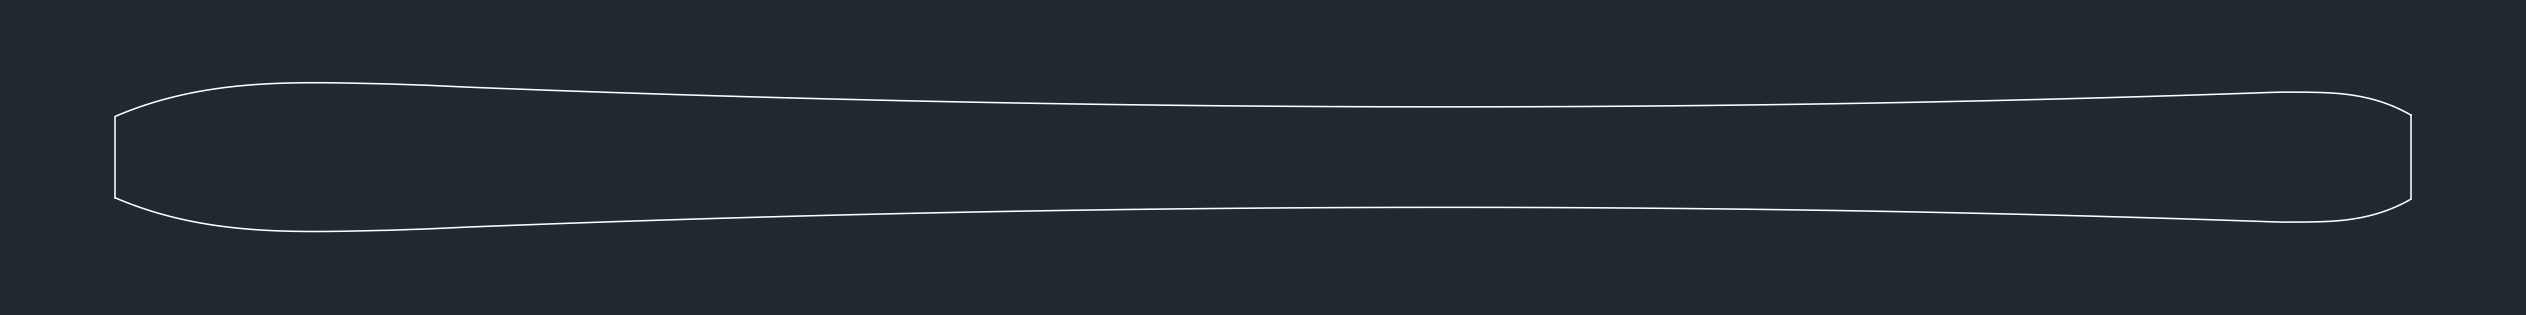

In [1151]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.
try:
    doc, auditor = recover.readfile(dxf_filename)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)